In [15]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader, random_split
from torchvision import transforms, datasets
import torchmetrics
from torchmetrics.classification import MulticlassF1Score

In [16]:
def set_seed( seed ) :
    random.seed( seed )
    np.random.seed( seed )
    torch.manual_seed( seed )
    torch.cuda.manual_seed ( seed )
    torch.cuda.manual_seed_all ( seed )
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    seed = 59
    set_seed ( seed )

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [17]:
root_dir = "/kaggle/input/aiomodule6imageweatherdataset/weather-dataset/dataset"
img_size = 128
train_percent = 0.8

transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
])

### Load dataset
dataset = datasets.ImageFolder(
    root = root_dir,
    transform = transform
)

### Split dataset
train_size = int(train_percent*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
# class2id: maps class name to label index
class2id = dataset.class_to_idx

# id2class: maps label index to class name
id2class = {v: k for k, v in class2id.items()}

print("class2id:", class2id)
print("id2class:", id2class)


class2id: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}
id2class: {0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


Shape: torch.Size([3, 128, 128])
Label ID: 8
Class Name: rime


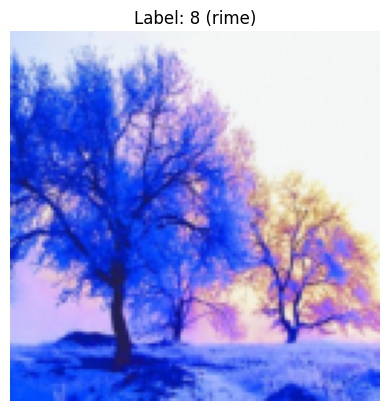

In [19]:
# Get first image and label
image_tensor, label = train_dataset[0]

# Print shape of tensor
print("Shape:", image_tensor.shape)  # (C, H, W)

# Print label and class name
print("Label ID:", label)
print("Class Name:", id2class[label])

# Convert tensor to numpy image for plotting
image_np = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)

# Plot
plt.imshow(image_np)
plt.title(f"Label: {label} ({id2class[label]})")
plt.axis("off")
plt.show()

In [20]:
loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

# Accumulate sum and squared sum
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 22/22 [00:18<00:00,  1.19it/s]

Mean: tensor([0.5168, 0.5256, 0.5065])
Std: tensor([0.1852, 0.1790, 0.1854])


In [21]:
additional_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

train_dataset.transform = additional_transform
test_dataset.transform = additional_transform

### Split dataset
test_percent=0.5
test_size = int(test_percent*len(test_dataset))
val_size = len(test_dataset) - test_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

len(train_dataset), len(val_dataset), len(test_dataset)

(5489, 687, 686)

# Create dataloader

In [22]:
from torch.utils.data import DataLoader

batch_size = 32  # or any value you prefer

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

for name, loader in [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]:
    images, labels = next(iter(loader))
    print(f"{name} - images: {images.shape}, labels: {labels.shape}")

Train - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])
Val - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])
Test - images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])


# Model Construction

### Residual Layer
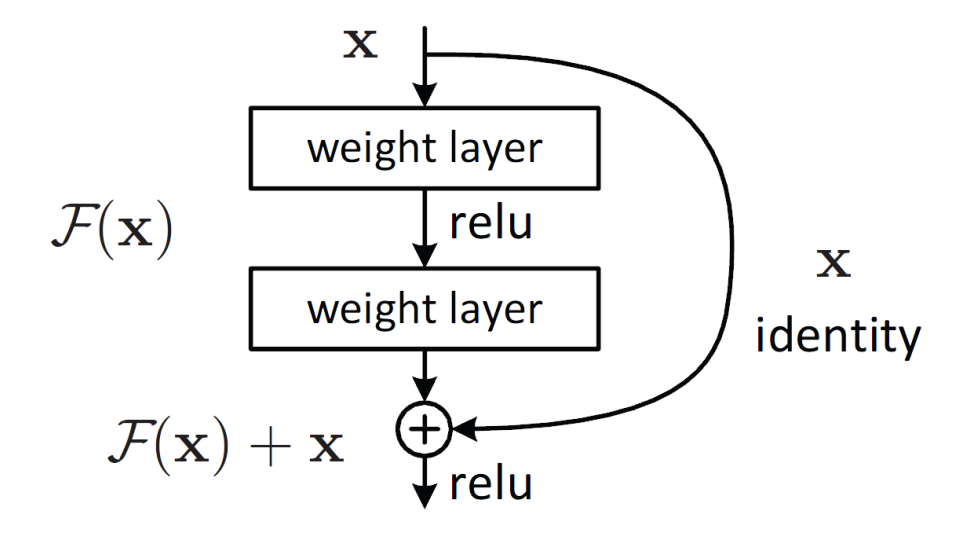

In [23]:
class Residual_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        self.Residual_Layer = nn.Sequential(
            nn.Conv2d(in_channels , out_channels , kernel_size=3 , stride = stride , padding = 1),
            nn.BatchNorm2d (out_channels),
            
            nn.LeakyReLU(0.1),

            nn.Conv2d(out_channels , out_channels , kernel_size=3 , stride = 1 , padding = 1),
            nn.BatchNorm2d (out_channels)
        ) 

        if in_channels != out_channels:
            self.x_projection = nn.Sequential(  # projection
                nn.Conv2d(in_channels , out_channels , kernel_size=1 , stride = stride),
                nn.BatchNorm2d (out_channels)
            )
        else:
            self.x_projection = nn.Sequential()  # identity
            
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x_project = self.x_projection(x)
        x = self.Residual_Layer(x) + x_project
        x = self.leaky_relu(x)
        return x

### Residual Block

In [24]:
class Residual_Block(nn.Module):
     def __init__(self, in_channels, out_channels, stride, num_layers):
         super().__init__()
         
         layers = [Residual_Layer(in_channels, out_channels, stride)]
         for _ in range(1, num_layers):
             layers.append(
                 Residual_Layer(out_channels, out_channels, 1)
             )
             
         self.Residual_Block = nn.Sequential(*layers)

     def forward(self, x):
         x = self.Residual_Block(x)
         return x

### ResNet
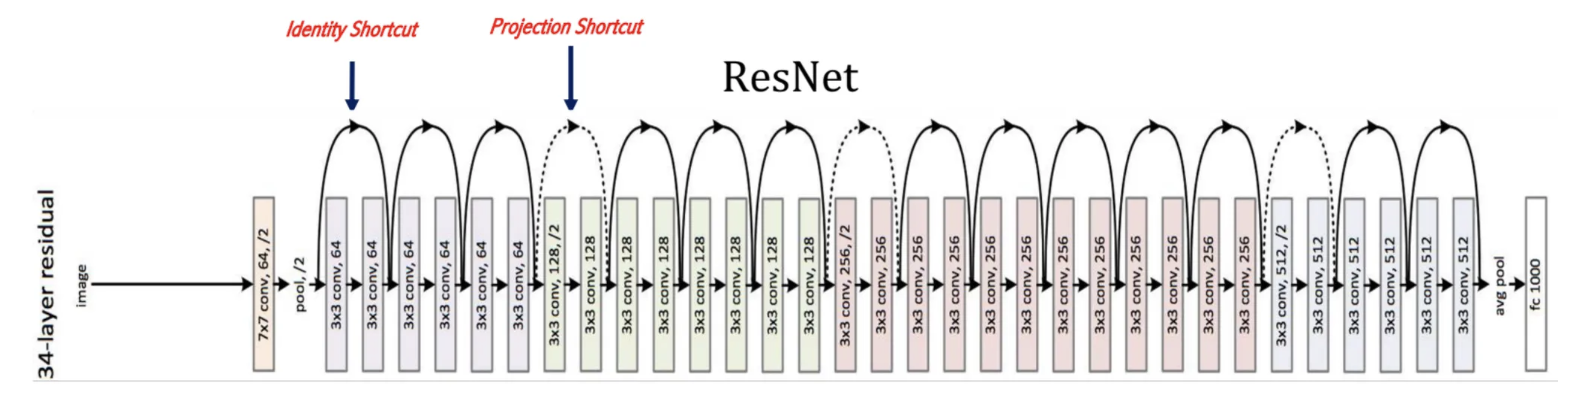

In [25]:
class ResNet(nn.Module):
    def __init__(self, num_layers: list, num_classes):
        super().__init__()
        
        blocks = [
            nn.Conv2d(3 , 64 , kernel_size=7 , stride = 2 , padding = 3),
            nn.BatchNorm2d (64),
            nn.LeakyReLU(0.1),
            
            nn.MaxPool2d(2,2),
            
            Residual_Block(64, 64, 1, num_layers[0]),
            Residual_Block(64, 128, 2, num_layers[1]),
            Residual_Block(128, 256, 2, num_layers[2]),
            Residual_Block(256, 512, 2, num_layers[3]),
        ]
        
        self.feature_extractor = nn.Sequential(*blocks)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [26]:
model = ResNet([3, 4, 6, 3], num_classes = 11)

In [29]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
         LeakyReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        LeakyReLU-10           [-1, 64, 56, 56]               0
   Residual_Layer-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
        LeakyReLU-14           [-1, 64,

# Training

In [30]:
def evaluate(model, test_dataloader, criterion, metric, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

    loss = sum(losses) / len(losses)
    metric_score = metric.compute().item()

    return loss, metric_score

In [35]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    model.to(device)
    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            
            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = metric.compute().item()
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, metric, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"""
            EPOCH {epoch + 1}:\n
            \tTrain loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\n
            \tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}
            """)
        
    return train_losses, train_accs, val_losses, val_accs


In [36]:
lr = 1e-2
epochs = 25

model = ResNet([3, 4, 6, 3], num_classes = 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)
metric = MulticlassF1Score(num_classes=11, average='macro').to(device)

In [37]:
results = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
)


                  EPOCH 1:

                  	Train loss: 1.4512	Train Acc: 0.4529

                  	Val loss: 3.0303	Val Acc: 0.4351
               

                  EPOCH 2:

                  	Train loss: 1.0714	Train Acc: 0.5178

                  	Val loss: 2.6972	Val Acc: 0.5093
               

                  EPOCH 3:

                  	Train loss: 0.9054	Train Acc: 0.5598

                  	Val loss: 1.3549	Val Acc: 0.5596
               

                  EPOCH 4:

                  	Train loss: 0.7304	Train Acc: 0.6008

                  	Val loss: 3.7113	Val Acc: 0.5934
               

                  EPOCH 5:

                  	Train loss: 0.5675	Train Acc: 0.6319

                  	Val loss: 2.4388	Val Acc: 0.6261
               

                  EPOCH 6:

                  	Train loss: 0.4476	Train Acc: 0.6591

                  	Val loss: 1.7517	Val Acc: 0.6568
               

                  EPOCH 7:

                  	Train loss: 0.3497	Train Acc

In [38]:
def plot_results(Training_Loss, Training_Acc, val_Loss, val_Acc):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(val_Loss, color="green", label="val Loss")
    plt.title("Training and val Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Training_Acc, color="blue", label="Training Accuracy")
    plt.plot(val_Acc, color="green", label="val Accuracy")
    plt.title("Training and val Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy value")
    plt.legend()

    plt.tight_layout()
    plt.show()

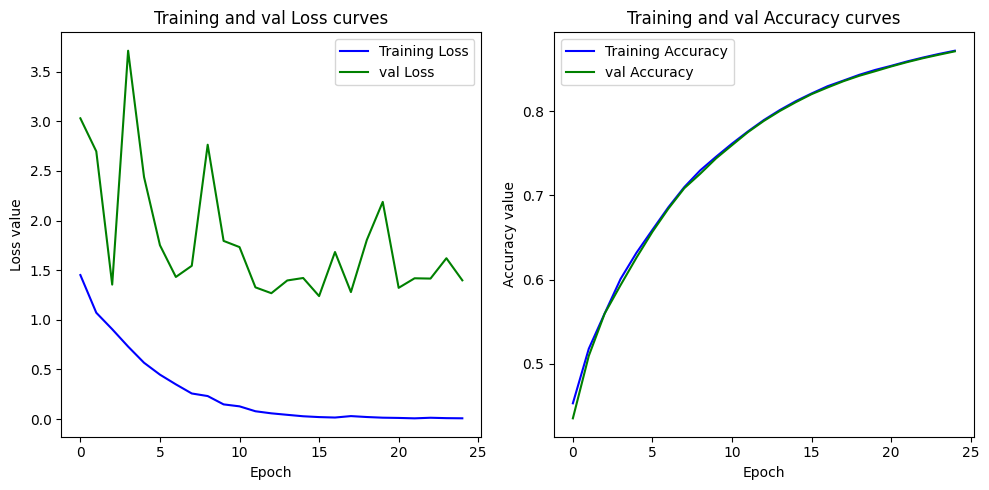

In [39]:
plot_results(results[0], results[1], results[2], results[3])

# Evaluate on Test

In [40]:
test_loss, test_acc = evaluate(
    model, test_loader, criterion, metric, device
)

print(test_loss, test_acc)

1.3833096650513736 0.8703639507293701
